# tSNE plots

In this notebook, we replicate the tSNE plots produced in the paper.

In [ ]:
import numpy as np
import sys
import os
import joblib
import torch
import tqdm

sys.path.append('../')

from utils.data_utils import dotdict
from utils.fetch_global_args import stage1_global_argparser, stage2_global_argparser
import utils.model_pipeline_mean as model_pipeline

In [ ]:
DATA_DIR = '../data/'

STAGE1_FILE = '../model_zoo/stage1/resnet.py'
STAGE1_CP = '../models/resnet_stage1/'
STAGE2_CP = '../models/resnet_stage2/'

DNASE_PATH = os.path.join(DATA_DIR, 'packbited')
RNA_PATH_TRAIN = os.path.join(DATA_DIR, 'rna_quants_1630tf.joblib')
RNA_PATH_IMPUTE = os.path.join(DATA_DIR, 'rna_quants_1630tf_to_impute.joblib')

rna_quant_data_train = joblib.load(RNA_PATH_TRAIN)
NUM_CTYPES_TRAIN = rna_quant_data_train['rna_quants'].shape[0]

rna_quant_data_impute = joblib.load(RNA_PATH_IMPUTE)
NUM_CTYPES_IMPUTE = rna_quant_data_impute['rna_quants'].shape[0]

In [ ]:
# set up model and load from checkpoint
import model_zoo.stage2.simple as s2

# chromosomes of interest (select all for full analysis)
chrmsoi = list(range(1,23)) + ['X','Y']

parser = stage2_global_argparser()
args = parser.parse_args(['-cp', STAGE2_CP,
                          '--stage1_file', STAGE1_FILE,
                          '--stage1_pretrained_model_path', STAGE1_CP, 
                          '--dnase', DNASE_PATH,
                          '--rna_quants', RNA_PATH_TRAIN,
                          '--with_mean', '1',
                          '-rb', '1'])

args = dotdict(vars(args))
args.chromosomes = chrmsoi

In [ ]:
model = s2.runner.instantiate_model_stage2(args, s2.Net, model_pipeline)
di = s2.runner.load_data_iterator_stage2(args)

## Predictions

In [ ]:
model.eval()

In [ ]:
SUBSAMPLE_TO = 100   # set to 10000 or more for accurate plots
ss = int(di.dnase_labels.shape[0]/SUBSAMPLE_TO)

dnase_labels = di.dnase_labels
dnase_labels = np.array(np.unpackbits(dnase_labels, axis=-1), dtype=np.int8)
dnase_labels = dnase_labels[:, :NUM_CTYPES_TRAIN][::ss]

In [ ]:
sequences = di.dnase_data[::ss]
sequences = np.array(np.unpackbits(sequences, axis=-1), dtype=np.float32)
sequences = sequences[:, :, :4]

In [ ]:
# Run the model on sequences STAGE 2 for 
ctois = range(NUM_CTYPES_IMPUTE)
BATCH_SIZE = 128
preds = []

with torch.no_grad():
    for ctoi in tqdm.tqdm(ctois, desc='cell type'):
        cur_preds = []
        for i in tqdm.tqdm(range(0, len(sequences),BATCH_SIZE), desc='batches'):
            s = torch.from_numpy(sequences[i:i+BATCH_SIZE]).cuda()
            g = torch.FloatTensor(np.tile(rna_quant_data_impute['rna_quants'][ctoi], (s.size(0),1))).cuda()
            m = torch.FloatTensor(np.mean(dnase_labels[i:i+BATCH_SIZE][:, sorted(list(di.train_cell_types))], axis=1)).cuda()   # mean computed on training cells
            x = model(s, g, m)
            out = torch.exp(x)[:,1]
            cur_preds.append(out.data.cpu().numpy())
        
        cur_preds = np.concatenate(cur_preds)
        preds.append(cur_preds)
            
preds = np.array(preds).T

## Plotting

In [ ]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing, decomposition
import random

def reduce_data(data, perplexity = 30, method = 'sklearn'):
    if method == 'sklearn':
        X = PCA(n_components = 100).fit_transform(data)
        #X = data
        tsne_reduction = TSNE(n_components = 2, perplexity= perplexity, 
                         learning_rate = 200, random_state = random.randint(0,100),
                        early_exaggeration = 12)
        Y = tsne_reduction.fit_transform(X)
        print(tsne_reduction.kl_divergence_)
    else:
        Y = t.tsne(data,  no_dims=2, initial_dims=100, perplexity=perplexity)
    return Y

def flatten_dict_of_dicts(data):
    assert(type(data) == dict and type(data[next(iter(data.keys()))]) == dict)
    flatten_cell = lambda x:  np.hstack((next(iter(y.values())) for y in data[x].values()))
    matrix = np.vstack(tuple(map(flatten_cell, data.keys())))
    return matrix

In [ ]:
# To use predictions computed in this notebook (above), uncomment the line below
# and comment out the two lines below it that load from file
# preds_matrix = preds

# loading precomputed genome wide predictions. 
preds = joblib.load(os.path.join(DATA_DIR, 'resnet_mean_preds.joblib'))

rna = rna_quant_data_impute

In [ ]:
# tSNE reduction
rna_reduced = reduce_data(rna['rna_quants'])
preds_accs_reduced = reduce_data(preds_matrix)

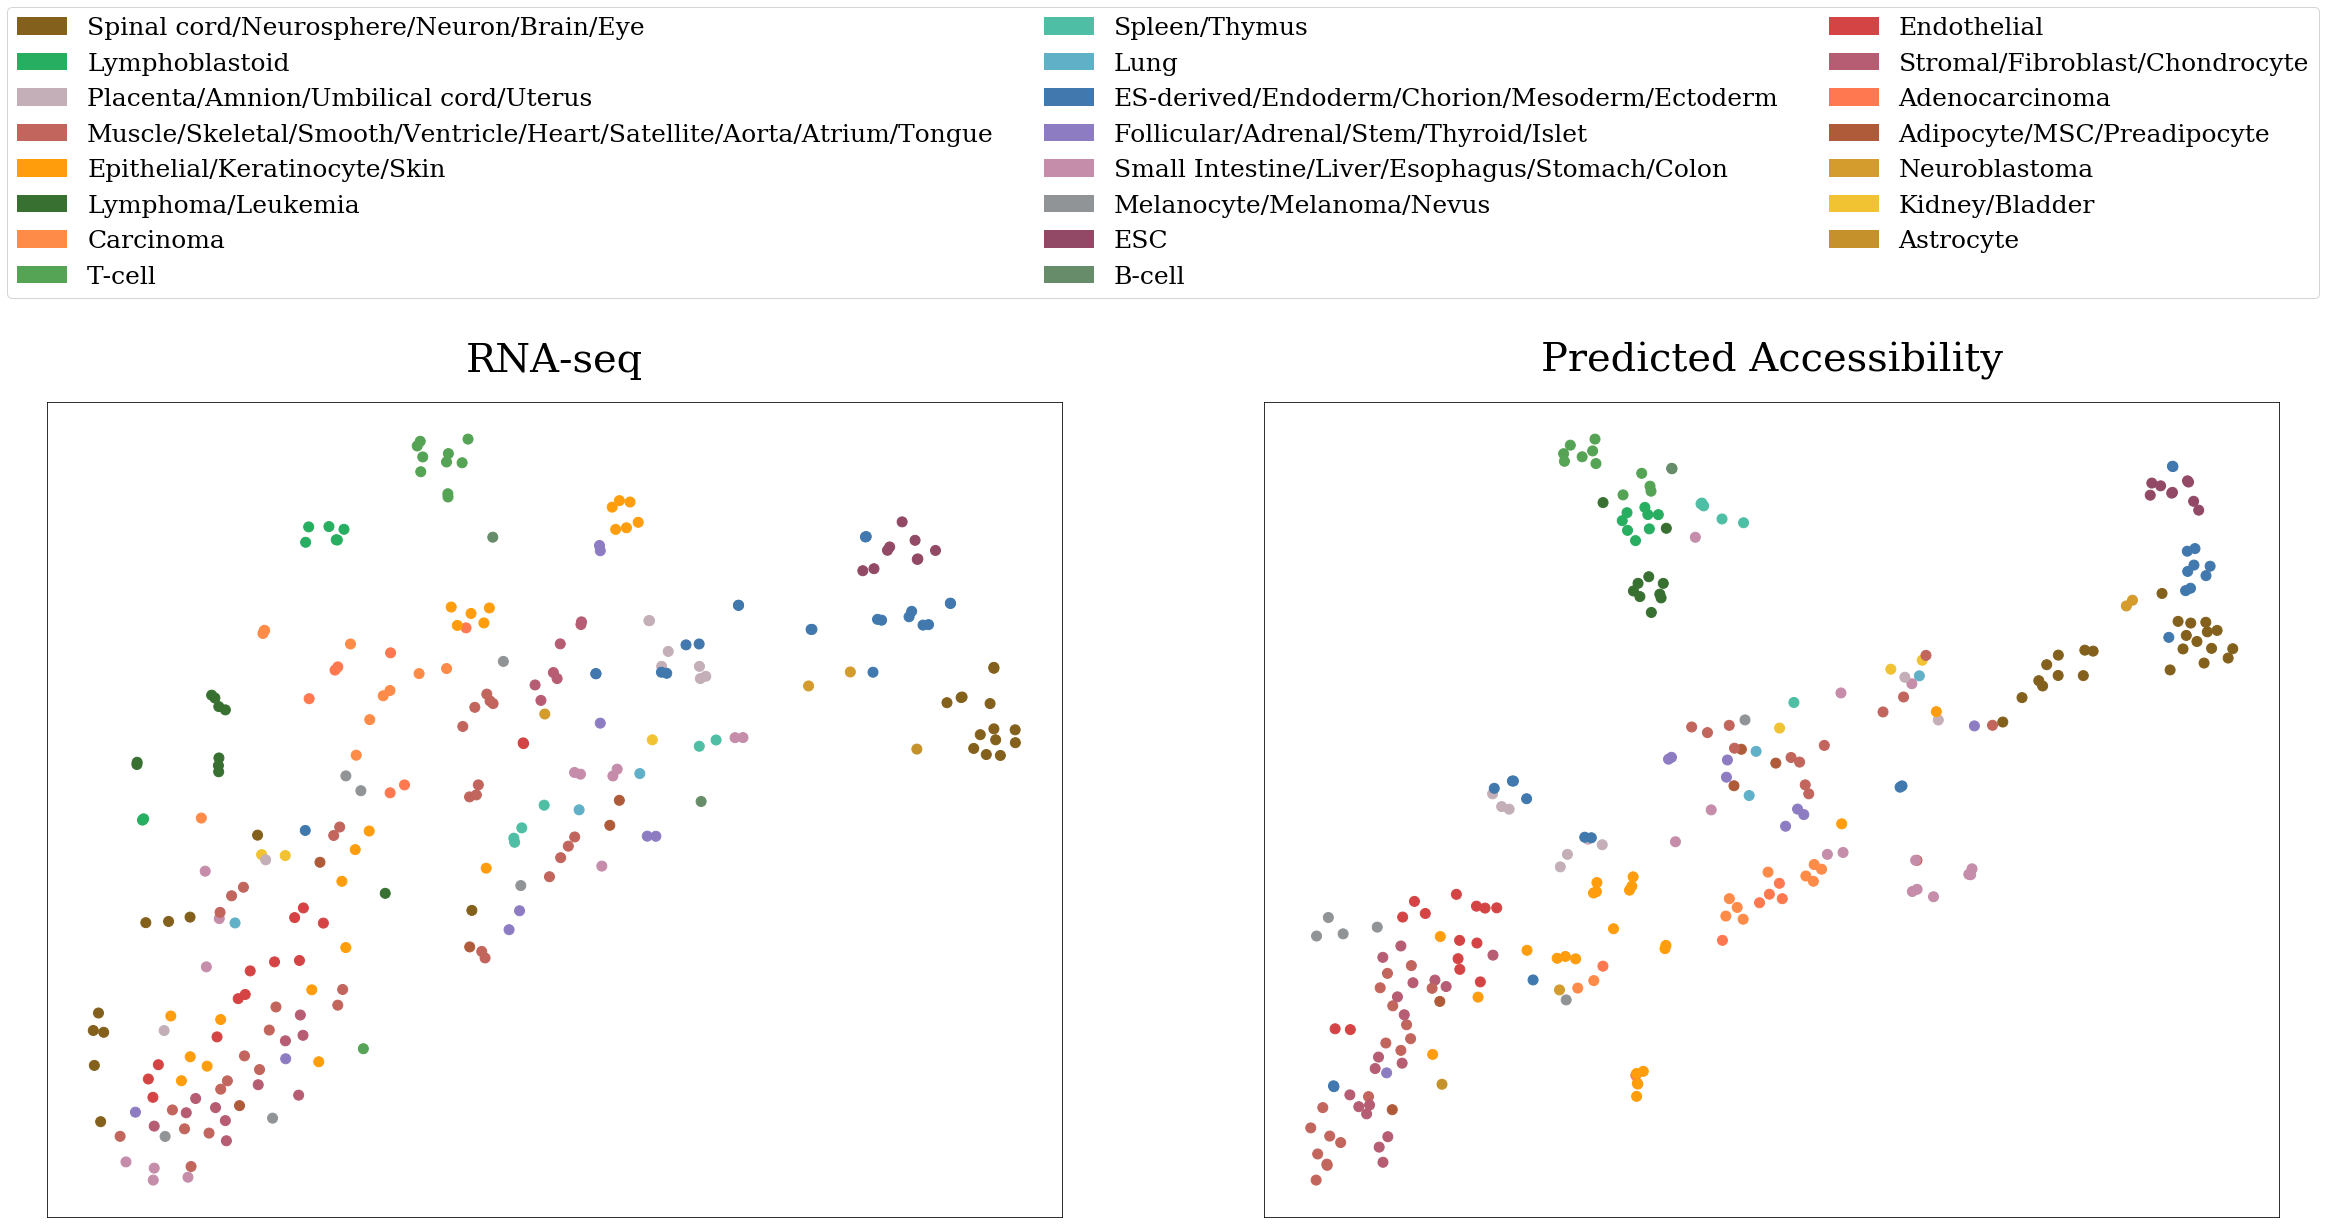

In [41]:
plt.rcParams["axes.titlesize"] = 40
plt.rc('font', family='serif')

plt.subplots(1,2, figsize=(40,15))
plt.subplot(1,2,1)
plt.scatter(rna_reduced[:,0], rna_reduced[:,1], c=rna['metadata']['color'],  s=100)
frame = plt.gca()
frame.get_xaxis().set_visible(False)
frame.get_yaxis().set_visible(False)
plt.title('RNA-seq', y=1.03)

plt.subplot(1,2,2)
plt.scatter(preds_accs_reduced[:,0], preds_accs_reduced[:,1], c=rna['metadata']['color'],  s=100)
frame = plt.gca()
frame.get_xaxis().set_visible(False)
frame.get_yaxis().set_visible(False)
plt.title('Predicted Accessibility', y=1.03)


for cl in color2ctype:
    plt.bar(0, 0, color=cl, label=color2ctype[cl], linewidth=0)
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.5), fontsize=25, ncol=3)   

plt.savefig('FiguresForPaper/tsne.pdf', bbox_inches='tight')